In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\kikma\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### Get and clean data

In [2]:
#Source: https://www.e-stat.go.jp/en/regional-statistics/ssdsview/municipality
tokyo_df = pd.read_csv('https://raw.githubusercontent.com/kikman-git/Coursera_Capstone/master/Tokyo_Pop.csv')
tokyo_df.head()

Id Neighborhood  Population
0  131211       Adachi      670122
1  131059       Bunkyo      219724
2  131016      Chiyoda       58406
3  131067        Taito      198073
4  131091    Shinagawa      386855

In [1]:
def get_latlong(neighborhood):
    """A function to get Latitude and Longitude using Google API"""
    import googlemaps
    gmaps = googlemaps.Client(key='API key')
    latlng =[]
    loading = 'Loading.'
    for i in neighborhood:
        string = '{}, Tokyo, Japan'.format(i)
        print(loading,end='')
        loading ='.'
        geocode_result = gmaps.geocode(string) #This will result in a json file so we need to know where to get the information
        latlng.append(geocode_result[0]['geometry']['location']) # location = (lat,lng)      
    return latlng   

In [4]:
latlng = get_latlong(tokyo_df.Neighborhood.values)
latlng[:5]

Loading..............................................................

[{'lat': 35.775017, 'lng': 139.8044129},
 {'lat': 35.7078686, 'lng': 139.7524369},
 {'lat': 35.6940309, 'lng': 139.7537719},
 {'lat': 35.7125736, 'lng': 139.7802043},
 {'lat': 35.6091973, 'lng': 139.7303364}]

In [5]:
lat_list =[]
lng_list =[]
for i in latlng:
    lat_list.append(i['lat'])
    lng_list.append(i['lng'])
tokyo_df['Latitude'] = lat_list
tokyo_df['Longitude'] = lng_list
tokyo_df.head()

Id Neighborhood  Population   Latitude   Longitude
0  131211       Adachi      670122  35.775017  139.804413
1  131059       Bunkyo      219724  35.707869  139.752437
2  131016      Chiyoda       58406  35.694031  139.753772
3  131067        Taito      198073  35.712574  139.780204
4  131091    Shinagawa      386855  35.609197  139.730336

In [6]:
url = 'https://raw.githubusercontent.com/kikman-git/Coursera_Capstone/master/tokyo.json'
tokyo_json = requests.get(url).json()

In [7]:
test_df = tokyo_df.sort_values(by ='Neighborhood').reset_index(drop=True)
test_df.head()

Id Neighborhood  Population   Latitude   Longitude
0  131211       Adachi      670122  35.775017  139.804413
1  132284      Akiruno       80954  35.728590  139.293466
2  132071     Akishima      111539  35.705910  139.354016
3  134023    Aogashima         178  32.456994  139.765208
4  131181      Arakawa      212264  35.735934  139.783476

In [11]:
#Information for Foursquare API
CLIENT_ID = 'BECVQZKEXCCUXYVUV5TTYXQFTE2E3TACHNXYSBNL00QVVXAY' # your Foursquare ID
CLIENT_SECRET = 'WFXF553RQRLLNLPZXPSTAYQZIZKUJ1BW1IHOO4TVLBXXK21Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # top 100 venues

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    loading = 'Loading'
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(loading,end='')
        loading = '.'    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Done!')
    return(nearby_venues)

In [13]:
tokyo_venue = getNearbyVenues(names = tokyo_df['Neighborhood'],
                              latitudes = tokyo_df['Latitude'],
                              longitudes = tokyo_df['Longitude'])

Loading.............................................................Done!


In [15]:
tokyo_venue.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Adachi              35.775017              139.804413   
1       Adachi              35.775017              139.804413   
2       Adachi              35.775017              139.804413   
3       Adachi              35.775017              139.804413   
4       Adachi              35.775017              139.804413   

                                  Venue  Venue Latitude  Venue Longitude  \
0  MEGA Don Quijote (MEGAドン・キホーテ 環七梅島店)       35.778288       139.804967   
1                    Nitori (ニトリ 環七梅島店)       35.778259       139.803108   
2             Ikinari Steak (いきなり!ステーキ)       35.777730       139.802890   
3                      セブンイレブン 足立梅島2丁目店       35.777031       139.803106   
4                    レストラン メヒコ 足立区役所14階       35.774582       139.803969   

           Venue Category  
0          Discount Store  
1  Furniture / Home Store  
2              Steakhouse  
3       Convenience Store  
4              Restaurant

### Choropleth map

In [18]:
count_df= pd.DataFrame(tokyo_venue.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])['Venue'].count()).reset_index(drop = False)
count_df.columns = ['Neighborhood','Latitude','Longitude','Venues']

m = folium.Map([35.6762,139.6503], zoom_start=9.5,tiles='cartodbpositron')
choropleth = folium.Choropleth(
    geo_data=tokyo_json,
    data=test_df,
    columns=['Id','Population'],
    key_on='feature.properties.code', 
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Tokyo Population',
    highlight=True,
    line_color='black'
).add_to(m)

folium.LayerControl(collapsed=True).add_to(m)
for i in range(0,len(count_df)):
   folium.Circle(
     location=[count_df.iloc[i]['Latitude'], count_df.iloc[i]['Longitude']],
      geo_data="Tokyo",
       popup=str(count_df.iloc[i]['Neighborhood'])+":"+str(count_df.iloc[i]['Venues']),
      radius=float(count_df.iloc[i]['Venues']*30),
      color='crimson',
      fill=True,
      fill_color='blue'
   ).add_to(m)
m

### Top 15 neighborhoods

Text(0.5, 1.0, 'Top 15 neighborhoods in Tokyo')

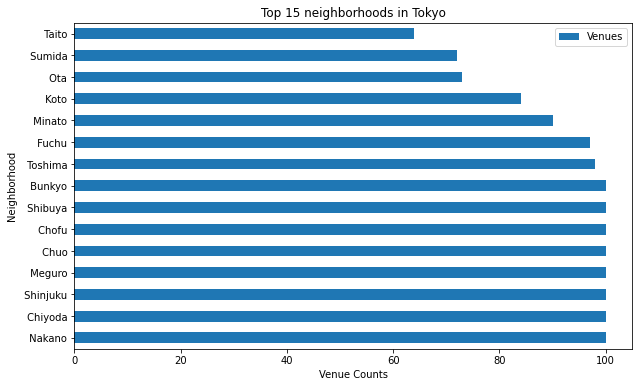

In [20]:
top15 = count_df.sort_values(by = 'Venues', ascending = False).head(15)
top15 = top15.drop(columns = ['Latitude','Longitude']).set_index('Neighborhood')
top15.plot(kind = 'barh', figsize =(10,6))
plt.xlabel('Venue Counts')
plt.ylabel('Neighborhood')
plt.title('Top 15 neighborhoods in Tokyo')

Text(0.5, 1.0, 'Top 10 Venue Category in Tokyo')

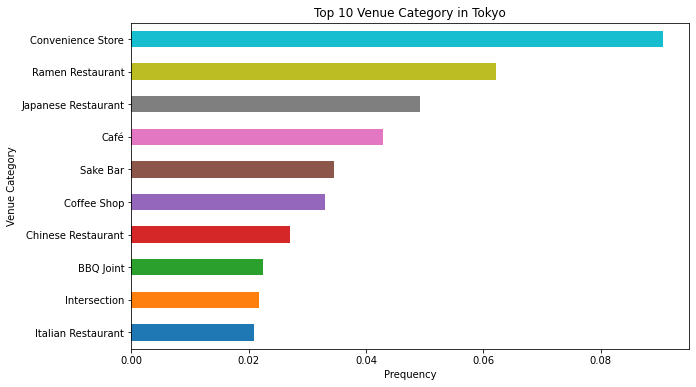

In [21]:
top_venues = pd.get_dummies(tokyo_venue['Venue Category'], prefix="", prefix_sep="").mean().sort_values().tail(10)
top_venues.plot(kind ='barh', figsize = (10,6))
plt.xlabel('Prequency')
plt.ylabel('Venue Category')
plt.title('Top 10 Venue Category in Tokyo')

In [22]:
print('There are {} uniques categories.'.format(len(tokyo_venue['Venue Category'].unique())))

There are 258 uniques categories.


### Explore each neighborhood

In [23]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venue['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venue['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()

Neighborhood  ATM  Acai House  Accessories Store  American Restaurant  \
0       Adachi    0           0                  0                    0   
1       Adachi    0           0                  0                    0   
2       Adachi    0           0                  0                    0   
3       Adachi    0           0                  0                    0   
4       Adachi    0           0                  0                    0   

   Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0             0         0       0            0           0   
1             0         0       0            0           0   
2             0         0       0            0           0   
3             0         0       0            0           0   
4             0         0       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   BBQ Joint  Baby Store  Bakery  Bar  Baseball Stadium  Basketball Court  \
0          0           0       0    0                 0                 0   
1          0           0       0    0                 0                 0   
2          0           0       0    0                 0                 0   
3          0           0       0    0                 0                 0   
4          0           0       0    0                 0                 0   

   Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0           0      0          0                0         0            0   
1           0      0          0                0         0            0   
2           0      0          0                0         0            0   
3           0      0          0                0         0            0   
4           0      0          0                0         0            0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0             0                         0          0           0       0   
1             0                         0          0           0       0   
2             0                         0          0           0       0   
3             0                         0          0           0       0   
4             0                         0          0           0       0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Brazilian Restaurant  \
0              0          0         0              0                     0   
1              0          0         0              0                     0   
2              0          0         0              0                     0   
3              0          0         0              0                     0   
4              0          0         0              0                     0   

   Breakfast Spot  Brewery  Bridge  Buddhist Temple  Buffet  Burger Joint  \
0               0        0       0                0       0             0   
1               0        0       0                0       0             0   
2               0        0       0                0       0             0   
3               0        0       0                0       0             0   
4               0        0       0                0       0             0   

   Bus Station  Bus Stop  Cafeteria  Café  Camera Store  Campground  \
0            0         0          0     0             0           0   
1            0         0          0     0             0           0   
2            0         0          0     0             0           0   
3            0         0          0     0             0           0   
4            0         0          0     0    

In [24]:
tokyo_onehot.shape

(2397, 259)

In [27]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.head()

Neighborhood  ATM  Acai House  Accessories Store  American Restaurant  \
0       Adachi  0.0         0.0                0.0                  0.0   
1      Akiruno  0.0         0.0                0.0                  0.0   
2     Akishima  0.0         0.0                0.0                  0.0   
3    Aogashima  0.0         0.0                0.0                  0.0   
4      Arakawa  0.0         0.0                0.0                  0.0   

   Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0           0.0       0.0     0.0          0.0         0.0   
1           0.0       0.0     0.0          0.0         0.0   
2           0.0       0.0     0.0          0.0         0.0   
3           0.0       0.0     0.0          0.0         0.0   
4           0.0       0.0     0.0          0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                  0.0               0.0                 0.0            0.0   
1                  0.0               0.0                 0.0            0.0   
2                  0.0               0.0                 0.0            0.0   
3                  0.0               0.0                 0.0            0.0   
4                  0.0               0.0                 0.0            0.0   

   BBQ Joint  Baby Store    Bakery  Bar  Baseball Stadium  Basketball Court  \
0   0.034483         0.0  0.034483  0.0               0.0               0.0   
1   0.066667         0.0  0.000000  0.0               0.0               0.0   
2   0.000000         0.0  0.000000  0.0               0.0               0.0   
3   0.000000         0.0  0.000000  0.0               0.0               0.0   
4   0.095238         0.0  0.000000  0.0               0.0               0.0   

   Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0         0.0    0.0        0.0              0.0       0.0          0.0   
1         0.0    0.0        0.0              0.0       0.0          0.0   
2         0.0    0.0        0.0              0.0       0.0          0.0   
3         0.0    0.0        0.0              0.0       0.0          0.0   
4         0.0    0.0        0.0              0.0       0.0          0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0           0.0                       0.0        0.0         0.0     0.0   
1           0.0                       0.0        0.0         0.0     0.0   
2           0.0                       0.0        0.0         0.0     0.0   
3           0.0                       0.0        0.0         0.0     0.0   
4           0.0                       0.0        0.0         0.0     0.0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Brazilian Restaurant  \
0            0.0        0.0       0.0            0.0                   0.0   
1            0.0        0.0       0.0            0.0                   0.0   
2            0.0        0.0       0.0            0.0                   0.0   
3            0.0        0.0       0.0            0.0                   0.0   
4            0.0        0.0       0.0            0.0                   0.0   

   Breakfast Spot  Brewery  Bridge  Buddhist Temple  Buffet  Burger Joint  \
0        0.034483      0.0     0.0              0.0     0.0           0.0   
1        0.000000      0.0     0.0              0.0     0.0           0.0   
2        0.000000      0.0     0.0              0.0     0.0           0.0   
3        0.000000      0.0     0.0              0.0     0.0           0.0   
4        0.000000      0.0     0.0              0.0     0.0           0.0   

   Bus Station  Bus Stop  Cafeteria      Café  Camera Store  Campground  \
0          0.0  0.103448        0.0  0.000000           0.0         0.0   
1          0.0  0.000000        0.0  0.000000           0.0         0.0   
2          0.0  0.000000        0.0  0.000000           0.0         0.0   
3          0.0  0.000000        0.0  0.000000           0.0         0.2   
4          0.

In [28]:
num_top_venues = 5

for hood in tokyo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adachi----
               venue  freq
0  Convenience Store  0.21
1           Bus Stop  0.10
2      Grocery Store  0.07
3       Intersection  0.07
4               Park  0.07


---- Akiruno----
                venue  freq
0    Ramen Restaurant  0.27
1   Convenience Store  0.20
2           BBQ Joint  0.07
3    Sushi Restaurant  0.07
4  Chinese Restaurant  0.07


---- Akishima----
               venue  freq
0  Convenience Store  0.67
1   Ramen Restaurant  0.17
2        Supermarket  0.17
3                ATM  0.00
4        Pizza Place  0.00


---- Aogashima----
                venue  freq
0      Scenic Lookout   0.2
1          Campground   0.2
2                Park   0.2
3       Historic Site   0.2
4  Sauna / Steam Room   0.2


---- Arakawa----
                venue  freq
0  Chinese Restaurant  0.14
1   Convenience Store  0.14
2           BBQ Joint  0.10
3        Intersection  0.10
4      Discount Store  0.05


---- Bunkyo----
                          venue  freq
0              Baseba

                 venue  freq
0                Hotel   0.2
1                Beach   0.1
2                Diner   0.1
3             Sake Bar   0.1
4  Yakitori Restaurant   0.1


---- Nishitokyo----
                 venue  freq
0    Convenience Store  0.18
1             Sake Bar  0.10
2          Coffee Shop  0.08
3     Ramen Restaurant  0.08
4  Japanese Restaurant  0.06


---- Ogasawara----
                     venue  freq
0         Sushi Restaurant  0.11
1                    Hotel  0.11
2  Comfort Food Restaurant  0.05
3   Gluten-free Restaurant  0.05
4                     Port  0.05


---- Okutama----
               venue  freq
0              Hotel  0.14
1        Bus Station  0.10
2               Café  0.10
3       Intersection  0.10
4  Convenience Store  0.10


---- Ome----
               venue  freq
0  Convenience Store  0.29
1   Ramen Restaurant  0.12
2           Sake Bar  0.06
3   Sushi Restaurant  0.06
4        Supermarket  0.06


---- Oshima----
                           venue  f

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.tail()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
57         Tachikawa          Intersection                Museum   
58             Taito     Convenience Store      Ramen Restaurant   
59              Tama     Convenience Store              Bus Stop   
60           Toshima                  Café      Ramen Restaurant   
61   Toshima village       Harbor / Marina                  Port   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
57              Bus Stop        Science Museum     Convenience Store   
58              Sake Bar                 Hotel   Japanese Restaurant   
59   Japanese Restaurant    Italian Restaurant          Intersection   
60   Japanese Restaurant              Sake Bar             BBQ Joint   
61             Dive Shop        History Museum           Zoo Exhibit   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
57           Zoo Exhibit           Flower Shop                  Food   
58            Art Museum            Bath House             Bookstore   
59                  Road                  Park           Bus Station   
60            Steakhouse           Coffee Shop      Sushi Restaurant   
61           Flower Shop                  Food     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  
57     Food & Drink Shop      French Restaurant  
58           Supermarket                   Café  
59           Candy Store     Chinese Restaurant  
60    Chinese Restaurant                    Bar  
61     French Restaurant    Fried Chicken Joint

### Find best K

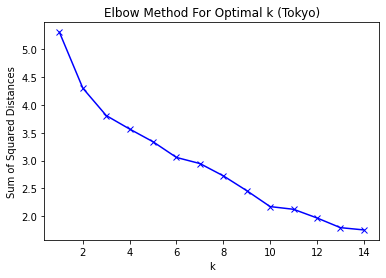

In [339]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tokyo_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k (Tokyo)')
plt.show()

### K-means Clustering

In [31]:
# set number of clusters
kclusters = 3

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [35]:
# add clustering labels
#neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1 , inplace = True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = test_df

# merge tokyo_grouped with tokyo_data to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
tokyo_merged.dropna(axis = 0, inplace = True)
tokyo_merged['Cluster Labels'] = tokyo_merged['Cluster Labels'].astype('int')

tokyo_merged.drop('Id', axis = 1).head() # check the last columns!

Neighborhood  Population   Latitude   Longitude  Cluster Labels  \
0       Adachi      670122  35.775017  139.804413               0   
1      Akiruno       80954  35.728590  139.293466               0   
2     Akishima      111539  35.705910  139.354016               0   
3    Aogashima         178  32.456994  139.765208               1   
4      Arakawa      212264  35.735934  139.783476               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Convenience Store              Bus Stop                  Park   
1      Ramen Restaurant     Convenience Store              Pharmacy   
2     Convenience Store           Supermarket      Ramen Restaurant   
3            Campground    Sauna / Steam Room        Scenic Lookout   
4    Chinese Restaurant     Convenience Store             BBQ Joint   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0          Intersection         Grocery Store            Kids Store   
1    Chinese Restaurant            Steakhouse      Sushi Restaurant   
2           Zoo Exhibit     French Restaurant         Fishing Store   
3         Historic Site                  Park     Food & Drink Shop   
4          Intersection        Discount Store         Memorial Site   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Bakery                 Diner            Restaurant   
1  Thrift / Vintage Store          Intersection             BBQ Joint   
2             Flower Shop                  Food     Food & Drink Shop   
3             Fish Market         Fishing Store           Flower Shop   
4                    Park         Grocery Store                  Café   

   10th Most Common Venue  
0        Ramen Restaurant  
1         Udon Restaurant  
2  Furniture / Home Store  
3                    Food  
4            Tram Station

In [36]:
cluster_1 = tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 0, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]
cluster_2 = tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 1, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]
cluster_3 = tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 2, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]
#cluster_4 = tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 3, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]
#cluster_5 = tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 4, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]

In [37]:
print('-----------Cluster 1------------')
cluster_1.iloc[:,2:3].apply(pd.Series.value_counts)

-----------Cluster 1------------


1st Most Common Venue
Convenience Store                      21
Chinese Restaurant                      1
Bakery                                  1
Park                                    1
Café                                    1
Bus Stop                                1
Drugstore                               1
Ramen Restaurant                        1
BBQ Joint                               1
Intersection                            1

In [38]:
print('-----------Cluster 2------------')
cluster_2.iloc[:,2:3].apply(pd.Series.value_counts)

-----------Cluster 2------------


1st Most Common Venue
Café                                     5
Convenience Store                        5
Ramen Restaurant                         5
Japanese Restaurant                      3
Intersection                             2
Hotel                                    2
Campground                               1
Baseball Stadium                         1
Harbor / Marina                          1
Bus Stop                                 1
Sushi Restaurant                         1
Plaza                                    1
Gift Shop                                1
Soba Restaurant                          1
Zoo Exhibit                              1

In [39]:
print('-----------Cluster 3------------')
cluster_3.iloc[:,2:3].apply(pd.Series.value_counts)

-----------Cluster 3------------


1st Most Common Venue
Scenic Lookout                      1